## Tractable Example for Bayes Factors ##

__M1:__:  
$Y_1, \ldots , Y_{N}, \sim N(\mu_1, \sigma^2); N = 10, \mu = 0$  
__M2__:  
$Y_1, \ldots , Y_{N1}, \sim N(\mu_1, \sigma^2); N_1 = 3, \mu_1 = -2$  
$Y_{N_1 + 1}, \ldots , Y_{N}, \sim N(\mu_2, \sigma^2); N_2 = N - N_1 = 7, \mu_2 = 2$

We fix $\sigma = 2$ and obtain data by drawing samples from __M2__:  
$Y = (-4.9, -2.25, -0.3, -0.3, 1.9, 2.1, 1.95, 5., 2.9, 3.43152853)$

In [2]:
import pandas as pd
import corner
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mcmc_utils import *
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


## Posteriors ##

We have three free parameters, $\mu, \mu_1, \mu_2$ and use the following strong priors:

- $\mu \sim N(0, \sigma^2)$
- $\mu_1 \sim N(-2, \sigma^2)$
- $\mu_2 \sim N(2, \sigma^2)$

Given priors, we can compute the posteriors as:
- $N(\frac{1}{N+1}\sum_{n=1}^{N}Y_n, \frac{\sigma^2}{N+1})$ for __M1__
- $N\begin{pmatrix}
\begin{pmatrix}
\frac{1}{N_1 +1}(-2 + \sum_{n=1}^{N_1} Y_n )\\ 
\frac{1}{N_2+1}(2 +\sum_{n= N_1 +1}^{N} Y_n )
\end{pmatrix},  & \begin{pmatrix}
\frac{\sigma^2}{N_1 + 1} & 0\\ 
0 & \frac{\sigma^2}{N_2 + 1}
\end{pmatrix}
\end{pmatrix}$ for __M2__

In [8]:
data = np.array([-4.9, -2.25, -0.3, -0.3, 1.9, 2.1, 1.95, 5., 2.9, 3.43152853])
m = np.mean(data)
m1 = np.mean(data[:3])
m2 = np.mean(data[3:])
mu = (1./11)*m*10
mu1 = (1./4)*(-2 + 3*m1)
mu2 = (1./8)*(2 + 7*m2)
print "Analytical Mean Values:", mu, mu1, mu2
print "Likelihoods:", calculate_log_likelihood_1(data, mu), calculate_log_likelihood_2(data, [mu1, mu2])

Analytical Mean Values: 0.866502593636 -2.3625 2.37269106625
Likelihoods: -25.777165527 -19.4492515132


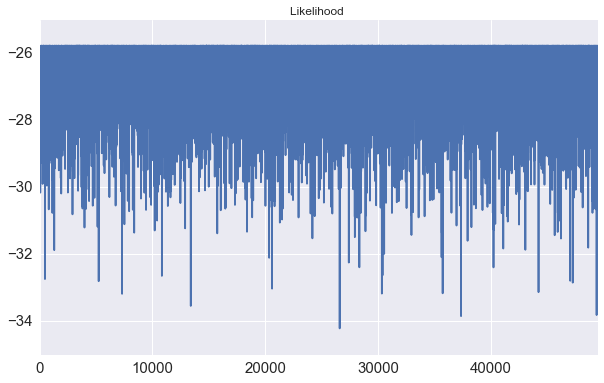

In [3]:
trace_plot("m1_prior/posteriors_m1_pt500k_20.csv", likelihood_only=True, verbose=0)

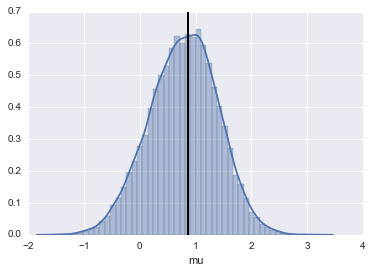

In [11]:
df = pd.read_table("m1_prior/posteriors_m1_pt500k_20.csv")
g = sns.distplot(df[50000::20]["mu"])
plt.plot([mu, mu], [0, 0.7], linewidth=2, color = "k")

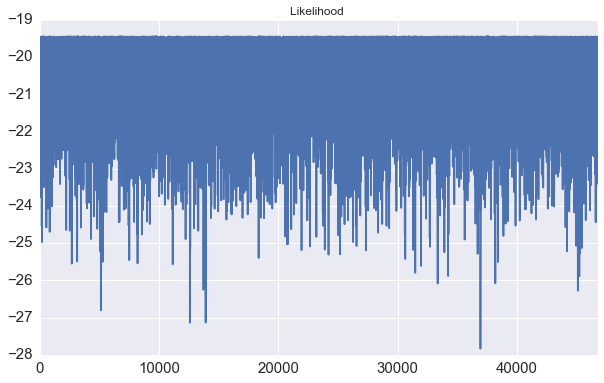

In [5]:
trace_plot("m2_prior/posteriors_m2_pt500k_20.csv", likelihood_only=True, verbose=0)

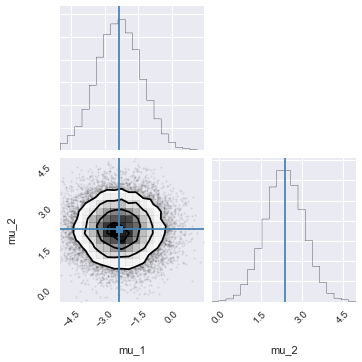

In [12]:
df = pd.read_table("m2_prior/posteriors_m2_pt500k_20.csv")
dd = df[["mu1", "mu2"]]
fig = corner.corner(dd[50000::20], labels = ["mu_1", "mu_2"], truths = [mu1, mu2])

## Bayes Factors ##


We compute Bayes Factors using Thermodynamic Integration. Best way to understand it by using the __power posterior__.

$p_\tau(\theta| \mathbf{Y}, \mathbf{M}) = \frac{1}{p_\tau(\mathbf{Y})} p(\mathbf{Y|\theta, \mathbf{M}})^\tau p(\theta)$

Now watch this:

$\frac{d}{d\tau}log\ p_\tau(\mathbf{Y}) = \frac{d}{d\tau} log \int p(\mathbf{Y|\theta, \mathbf{M}})^\tau p(\theta) d\theta$  
$=\int log \ p(\mathbf{Y|\theta, \mathbf{M}}) \frac{p(\mathbf{Y|\theta, \mathbf{M}})^\tau p(\theta)}{p_\tau(\mathbf{Y})}d\theta$  
$=E_{p_\tau}\left \{ log\ p(\mathbf(Y|\theta, \mathbf{M}) \right \}$

this means that:

$log\ p(\mathbf{Y}|\mathbf{M}) = \int_{0}^{1} E_{p_\tau}\left \{ log\ p(\mathbf(Y|\theta, \mathbf{M}) \right \}d\tau$  

This integral can be solved numerically (using a temperature ladder $\tau_{\cdot}$) to give the marginal likelihood:

$log\ p(\mathbf{Y}|\mathbf{M}) \approx 0.5 \sum_{k=0}^{K-1}(\tau_{k+1} - \tau_{k})(E_{p_{\tau_{k+1}}}\left \{ log\ p(\mathbf(Y|\theta, \mathbf{M}) \right \} - E_{p_{\tau_{k}}}\left \{ log\ p(\mathbf{Y}|\theta, \mathbf{M}) \right \})$

where we can obtain the expectation for a specific $\tau$ by the Monte Carlo estimate:

$E_{p_{\tau_{k}}}\left \{ log\ p(\mathbf{Y}|\theta, \mathbf{M}) \right \} \approx \frac{1}{S} \sum_{s=1}^{S} log\ p(\mathbf{Y}|\theta^{(s)}, \mathbf{M})$




## Bayes Factors for Gaussian Mixture Example ##

For the above two models, Baye's Factors can be obtained analytically as:

$log\ B_{12} = log (\sqrt{\frac{N+1}{(N_1 + 1)(N_2 + 1)}}) - \frac{1}{2\sigma^2}\left ( \frac{(N\mathbf{\bar{Y}})^2}{N+1} - \frac{(N_1\mathbf{\bar{Y}}_1 - 2)^2}{N_1 + 1} - \frac{(N_2\mathbf{\bar{Y}}_2 + 2)^2}{N_2 +1} + 8\right )$

In [33]:
## Analytical Bayes Factor
analogB21 = 0.5*log(11./32) - (1./8)*( ((10*m)*(10*m))/11. - ((3*m1-2)*(3*m1-2))/4. - ((7*m2+2)*(7*m2+2))/8. + 8.)
print "Analytical Bayes Factor:", analogB21

Analytical Bayes Factor: 5.85405893179


In [8]:
## get likelihood from file
def get_ll_from_file(dir_name, prefix):
    ll = pd.DataFrame()
    for i in range(1, 21):
        tmp = pd.read_table(os.path.join(dir_name, prefix + "_" + str(i) + ".csv"))
        ll["temp_"+str(i)] = tmp["LnLike"]
    return ll

## marginal likelihood function
def marginal_log_likelihood(likelihood, temps):
    """Gives the estimate for the marginal likelihood"""
    means = np.array(likelihood.mean(axis=0))*(1./temps)
    means = np.concatenate((np.array([0]), means))
    temps = np.concatenate((np.array([0]), temps))
    return 0.5*np.diff(temps).dot(means[:-1] + means[1:])

In [9]:
num_chains = 20
temps = np.array([1.*(i+1)/(num_chains) for i in range(num_chains)])**5
ll_m1 = get_ll_from_file("m1_prior", "posteriors_m1_pt500k")
ll_m2 = get_ll_from_file("m2_prior", "posteriors_m2_pt500k")

In [10]:
## marginal for M1
lnM1 = marginal_log_likelihood(ll_m1[50000::20], temps)
## marginal for M2
lnM2 = marginal_log_likelihood(ll_m2[50000::20], temps)
print "Marginal likelihoods:", lnM1, lnM2
lnB21 = lnM2 - lnM1
print "Analytical Bayes Factor:", analogB21
print "Bayes Factor:", lnB21

Marginal likelihoods: -27.1903855522 -21.0770338631
Bayes Factor: 6.1133516891


## Metropolis-Hastings Sampling ##

We also see how the MH sampler does on the above sampler.

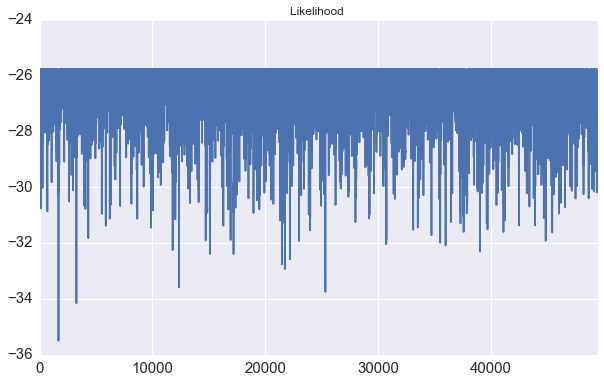

In [17]:
## M1 
trace_plot("m1_mh/posteriors_m1_mh500k_2.csv", likelihood_only=True, verbose=0)

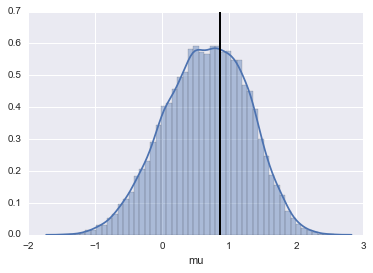

In [27]:
df1 = pd.read_table("m1_mh/posteriors_m1_mh500k_2.csv")
sns.distplot(df1[50000::20]["mu"])
plt.plot([mu, mu], [0, 0.7], linewidth=2, color = "k")

In [30]:
print "Likelihood:", df1[50000::20]["LnLike"].mean()

Likelihood: -26.3534947058


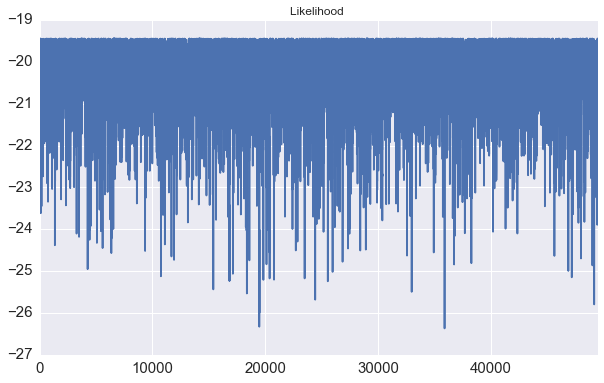

In [18]:
## M2
trace_plot("m2_mh/posteriors_m2_mh500k_2.csv", likelihood_only=True, verbose=0)

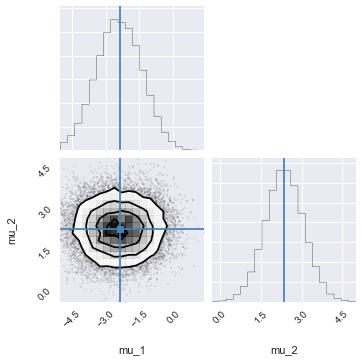

In [28]:
df2 = pd.read_table("m2_mh/posteriors_m2_mh500k_2.csv")
fig = corner.corner(df2[50000::20][["mu1", "mu2"]], labels = ["mu_1", "mu_2"], truths = [mu1, mu2])

In [29]:
print "Likelihood:", df2[50000::20]["LnLike"].mean()
print "Bayes Factor:", df2[50000::20]["LnLike"].mean() - df1[50000::20]["LnLike"].mean()

Likelihood: -20.2504067527
Bayes Factor: 6.10308795312
